### finetuning tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
# from transformers import DeiTFeatureExtractor, DeiTForImageClassification

# model = DeiTForImageClassification.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
# inputs = feature_extractor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
model = models.mobilenet_v3_small(pretrained=True)
# num_ftrs = model.fc.in_features

SyntaxError: invalid syntax (<ipython-input-29-cb47cbf354ed>, line 1)

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_folder_name = "train"
test_folder_name = "test"

data_transforms = {
    train_folder_name: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test_folder_name: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
    for x in [train_folder_name, test_folder_name]
} 
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in [train_folder_name, test_folder_name]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_folder_name, test_folder_name]}
class_names = image_datasets[train_folder_name].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class_names

['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
class_names = image_datasets[train_folder_name].classes

class_dict = {i:name for i, name in enumerate(list(class_names))}

import json
with open("labels_dict.json", "w") as f:
    json.dump(class_dict, f)

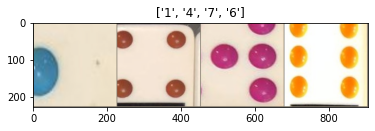

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_folder_name]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(inputs.size())
            print("class_names", class_names)
            print("preds", preds)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(class_names[preds[j]])
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # outputs, logits = model(inputs)                    
                    outputs = model(inputs)
                    # print(outputs.logits)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 13)
model = model.to(device)

NameError: name 'num_ftrs' is not defined

In [39]:
num_ftrs

512

In [11]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model = train_model(
    model, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler,
    num_epochs=20,
)

Epoch 0/4
----------
train Loss: 1.1735 Acc: 0.6538
test Loss: 0.8954 Acc: 0.6923

Epoch 1/4
----------
train Loss: 0.5684 Acc: 0.8462
test Loss: 0.4965 Acc: 0.8462

Epoch 2/4
----------
train Loss: 0.3938 Acc: 0.8462
test Loss: 0.4886 Acc: 0.8462

Epoch 3/4
----------
train Loss: 0.4707 Acc: 0.8462
test Loss: 0.2428 Acc: 0.9231

Epoch 4/4
----------
train Loss: 0.7030 Acc: 0.8462
test Loss: 0.3531 Acc: 0.9231

Training complete in 0m 23s
Best test Acc: 0.923077


torch.Size([4, 3, 224, 224])
class_names ['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
preds tensor([ 1,  2, 11,  7])
1


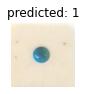

10


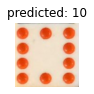

8


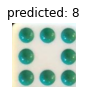

4


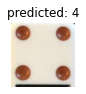

torch.Size([4, 3, 224, 224])
class_names ['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
preds tensor([ 8, 10,  5,  2])
5


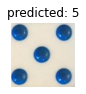

7


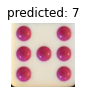

In [15]:
visualize_model(model)

### Saving pytorch model

In [16]:
model_name = "dominos_20210531"

In [17]:
torch.save(model.state_dict(), model_name + ".pkl")

### loading pytorch model

In [18]:
model.load_state_dict(torch.load(model_name+".pkl"))
model.eval()
print()

## Exporting of onnx models

In [19]:
# Input to the model
batch_size = 1
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
torch_out = model(x)

# Export the model
torch.onnx.export(
    model,               # model being run
    x,                         # model input (or a tuple for multiple inputs)
    model_name+".onnx",   # where to save the model (can be a file or file-like object)
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=12,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names = ['input'],   # the model's input names
    output_names = ['output'], # the model's output names
    dynamic_axes={
        'input' : {batch_size : 'batch_size'},    # variable length axes
        'output' : {batch_size : 'batch_size'}
    })

In [20]:
import onnx

onnx_model = onnx.load(model_name+".onnx")
print(onnx.checker.check_model(onnx_model))

None


In [21]:
import onnx
from onnxruntime.quantization import quantize_qat, QuantType

model_fp32 = model_name+".onnx"
model_quant = model_name+".quant.onnx"

quantized_model = quantize_qat(model_fp32, model_quant)

In [22]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(model_name+".onnx")
# ort_session = onnxruntime.InferenceSession('domino-onnx_2021-05-29.quant.onnx')

def to_numpy(tensor):
    # return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    return tensor.detach().cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [38]:
!python -m nnef_tools.convert --input-format onnx --output-format nnef --input-model domino-onnx_2021-05-29.onnx --fold-constants --input-shape "{'input': (2, 3, 224, 224)}"

Conversion for operation type(s) 'Erf' is not implemented


In [35]:
pip install future typing six numpy protobuf onnx onnx-simplifier onnxruntime

  Using cached future-0.18.2.tar.gz (829 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=152cd66c849df31ef44903fa4f6d913a46328a2147d551e8acc898c263a6ba28
  Stored in directory: c:\users\jeremy\appdata\local\pip\cache\wheels\8e\70\28\3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=d72d926c83b60dbefe054b3e3e64ad25480fd128bdf24c1e17ff4b3b0f242350
  Stored in directory: c:\users\jeremy\appdata\local\pip\cache\wheels\5e\5d\01\3083e091b57809dad979ea543def62d9d878950e3e74f0c930
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.5-py3-none-any.whl size=12863 sha256=3305ab7815683fb8f90271df3eeec9759c6af5a3aa0295a7ce3fa9c917fa71e0
  Stored in directory: c:\users\jeremy\appdata\local\pip\cache\wheels\67\41\4b\ab44ea796416a698b22f1445154937a23e2b867211b25d16f5
Successfully built future typing onnx-simplifier
Note: you may need to restart the kernel to 

In [42]:
!pip3 install onnx-simplifier

In [23]:
import onnx
from onnxsim import simplify

def simplify_and_save(model, save_name):
    # load your predefined ONNX model
    # model = onnx.load(f'{model_name}.onnx')

    # convert model
    model_simp, check = simplify(model, dynamic_input_shape=True, input_shapes={'input': (1, 3,224, 224)})

    assert check, "Simplified ONNX model could not be validated"
    onnx.save(model_simp, save_name)


In [24]:
model_fp32 = model_name+".onnx"
model_quant = model_name+".quant.onnx"


onnx_model = onnx.load(model_fp32)
simplify_and_save(onnx_model, "simplified.onnx")

onnx_model = onnx.load(model_quant)
simplify_and_save(onnx_model, "simplified.quant.onnx")

